In [2]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [9, 5]
plt.rcParams['figure.dpi'] = 300


#### Definimos: $$t(\omega)=\frac{-\kappa}{(\Omega-\omega)-i\kappa-i\frac{g^2}{i(\Delta E-\omega)+\gamma}}$$

In [3]:
def t_w (w, k, Omega, DeltaE, gamma, g):
    numerador = -k
    denominador = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = numerador / denominador
    return abs(t)

 # Sin ruido

## Creamos base de datos

In [4]:
#Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    return k, gamma, g

num_datos = 5000

In [5]:
# #Creamos base de datos y guardamos en .txt
# k, gamma, g = Parameters_generator (num_datos)
# np.savetxt('Parameters_noNoise_contourPlot.txt', np.column_stack((k, gamma, g)), header='\u03BA \u213D g') 

In [6]:
datos = np.loadtxt('Parameters_noNoise_contourPlot.txt', skiprows=1)
k = datos[:,0]
gamma = datos[:,1]
g = datos[:,2]
Omega = 1
DeltaE_values = np.linspace(0.95, 1.05, 21)

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(0.85, 1.15, 300)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(DeltaE_values), len(w_values)))

for i in range (num_datos):
    for j, DeltaE  in enumerate(DeltaE_values):
        t_values[i,j,:] = t_w(w_values, k[i], Omega, DeltaE, gamma[i], g[i])



## Dibujamos ***Contour plot***

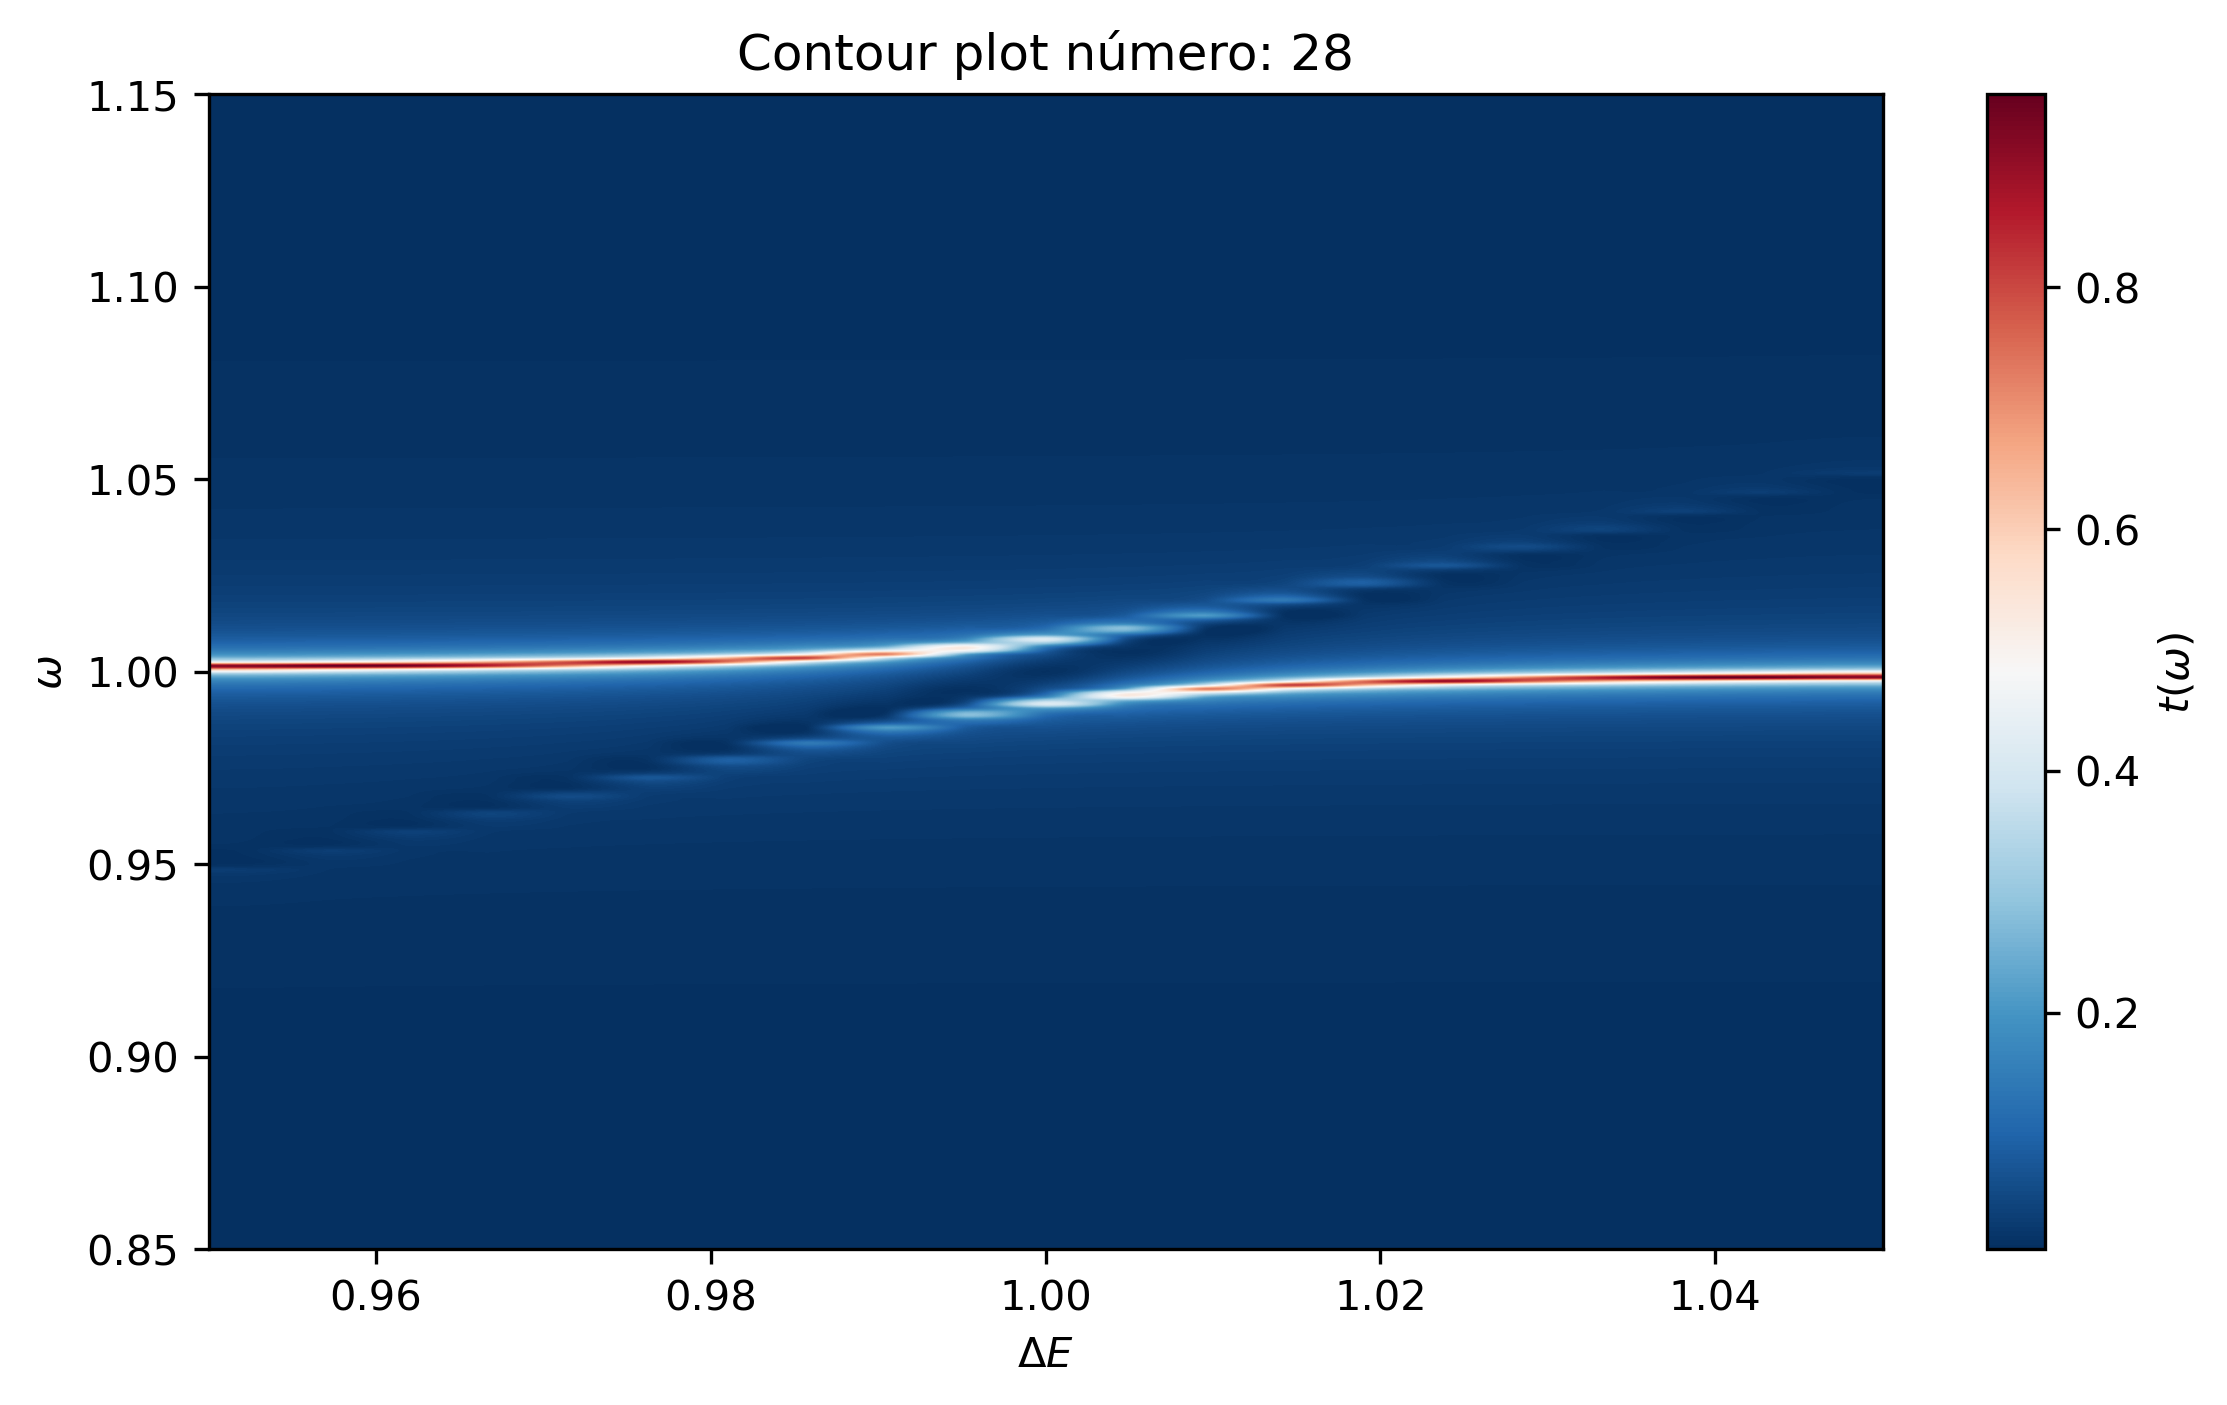

In [7]:
i=0
while i<=num_datos:
    plt.clf()  # Limpia la figura antes de cada iteración
    plt.imshow(t_values[i,:,:].T, extent=[DeltaE_values.min(), DeltaE_values.max(), w_values.min(), w_values.max()],
                    cmap='RdBu_r', origin='lower',
                      aspect='auto', interpolation='spline16') #Para evitar pixeles usar -spline16-, para pixeles -none- o -nearest-
    plt.colorbar(label=r'$t(\omega)$')
    plt.title(f"Contour plot número: {i}")
    plt.xlabel(r'$\Delta E$')
    plt.ylabel(r'$\omega$')
    display(plt.gcf())
    clear_output(wait=True)
    
    if keyboard.is_pressed('esc'): break
    if keyboard.is_pressed('right'): i += 1
    if keyboard.is_pressed('left'): 
        i -= 1       
        if i < 0:
            i += 1


## Red neuronal

### Tensorflow/Keras

In [8]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Preparamos datos e hiperparámetros

In [9]:
# Reshape para que entre algo 2D a StandardScaler
t_values_reshaped = t_values.reshape((num_datos, len(DeltaE_values) * len(w_values)))

#Seleccionamos los datos de entrenamiento y de validación
x_train, x_val, y_train, y_val = train_test_split(t_values_reshaped, datos, test_size=0.2)

# Normalizamos los datos
scaler_x = StandardScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)

scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)

# Comprobamos las dimensiones de nuestros datos
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)

#Número de neuronas de entrada y salida, y de la capa oculta
input_neurons  = x_train.shape[1]
output_neurons = y_train.shape[1]

#Elegimos los hiperparámetros
batch_size = 50
epochs = 1000
optimizer = Adam(learning_rate=0.001)


4000 train samples
1000 test samples
x_train shape (4000, 6300)
y_train shape (4000, 3)


#### Definimos modelos

##### 5 capas ocultas



In [10]:
def Dense_five ():
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32 , activation='relu'))
    model.add(Dense(16 , activation='relu'))
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg())) 

    #Compila el modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

 #### Entrenamos y guardamos

In [11]:
# model =  Dense_five()

# #Fiteamos el modelo
# history = model.fit(x_train_norm, y_train_norm, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm),
#                      epochs=epochs, verbose=2)

# # # Definir EarlyStopping
# # early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# #Guardamos el modelo y así no necesitamos entrenarlo cada vez que lo queramos usar
# model.save('model_noNoise_five_ContourPlot.keras') 

# # Visualiza la pérdida y la métrica de entrenamiento
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['mean_absolute_error'], label='Train MAE')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

#### Llamamos y evaluamos

In [12]:
#LLamamos al modelo
model = models.load_model("model_noNoise_five_ContourPlot.keras")

#model.summary()

#Evaluamos el modelo
scores = model.evaluate(x_val_norm, y_val_norm, verbose=0)
print('MSE',scores[0],'\nMAE:', scores[1])  


#Predecimos los valores con nuestro modelo
y_pred_norm = model.predict(x_val_norm)

MSE 0.03520279750227928 
MAE: 0.07302040606737137
32/32 [==============================] - 0s 1ms/step


#### Dibujamos los resultados

Predicción de cada parámetro

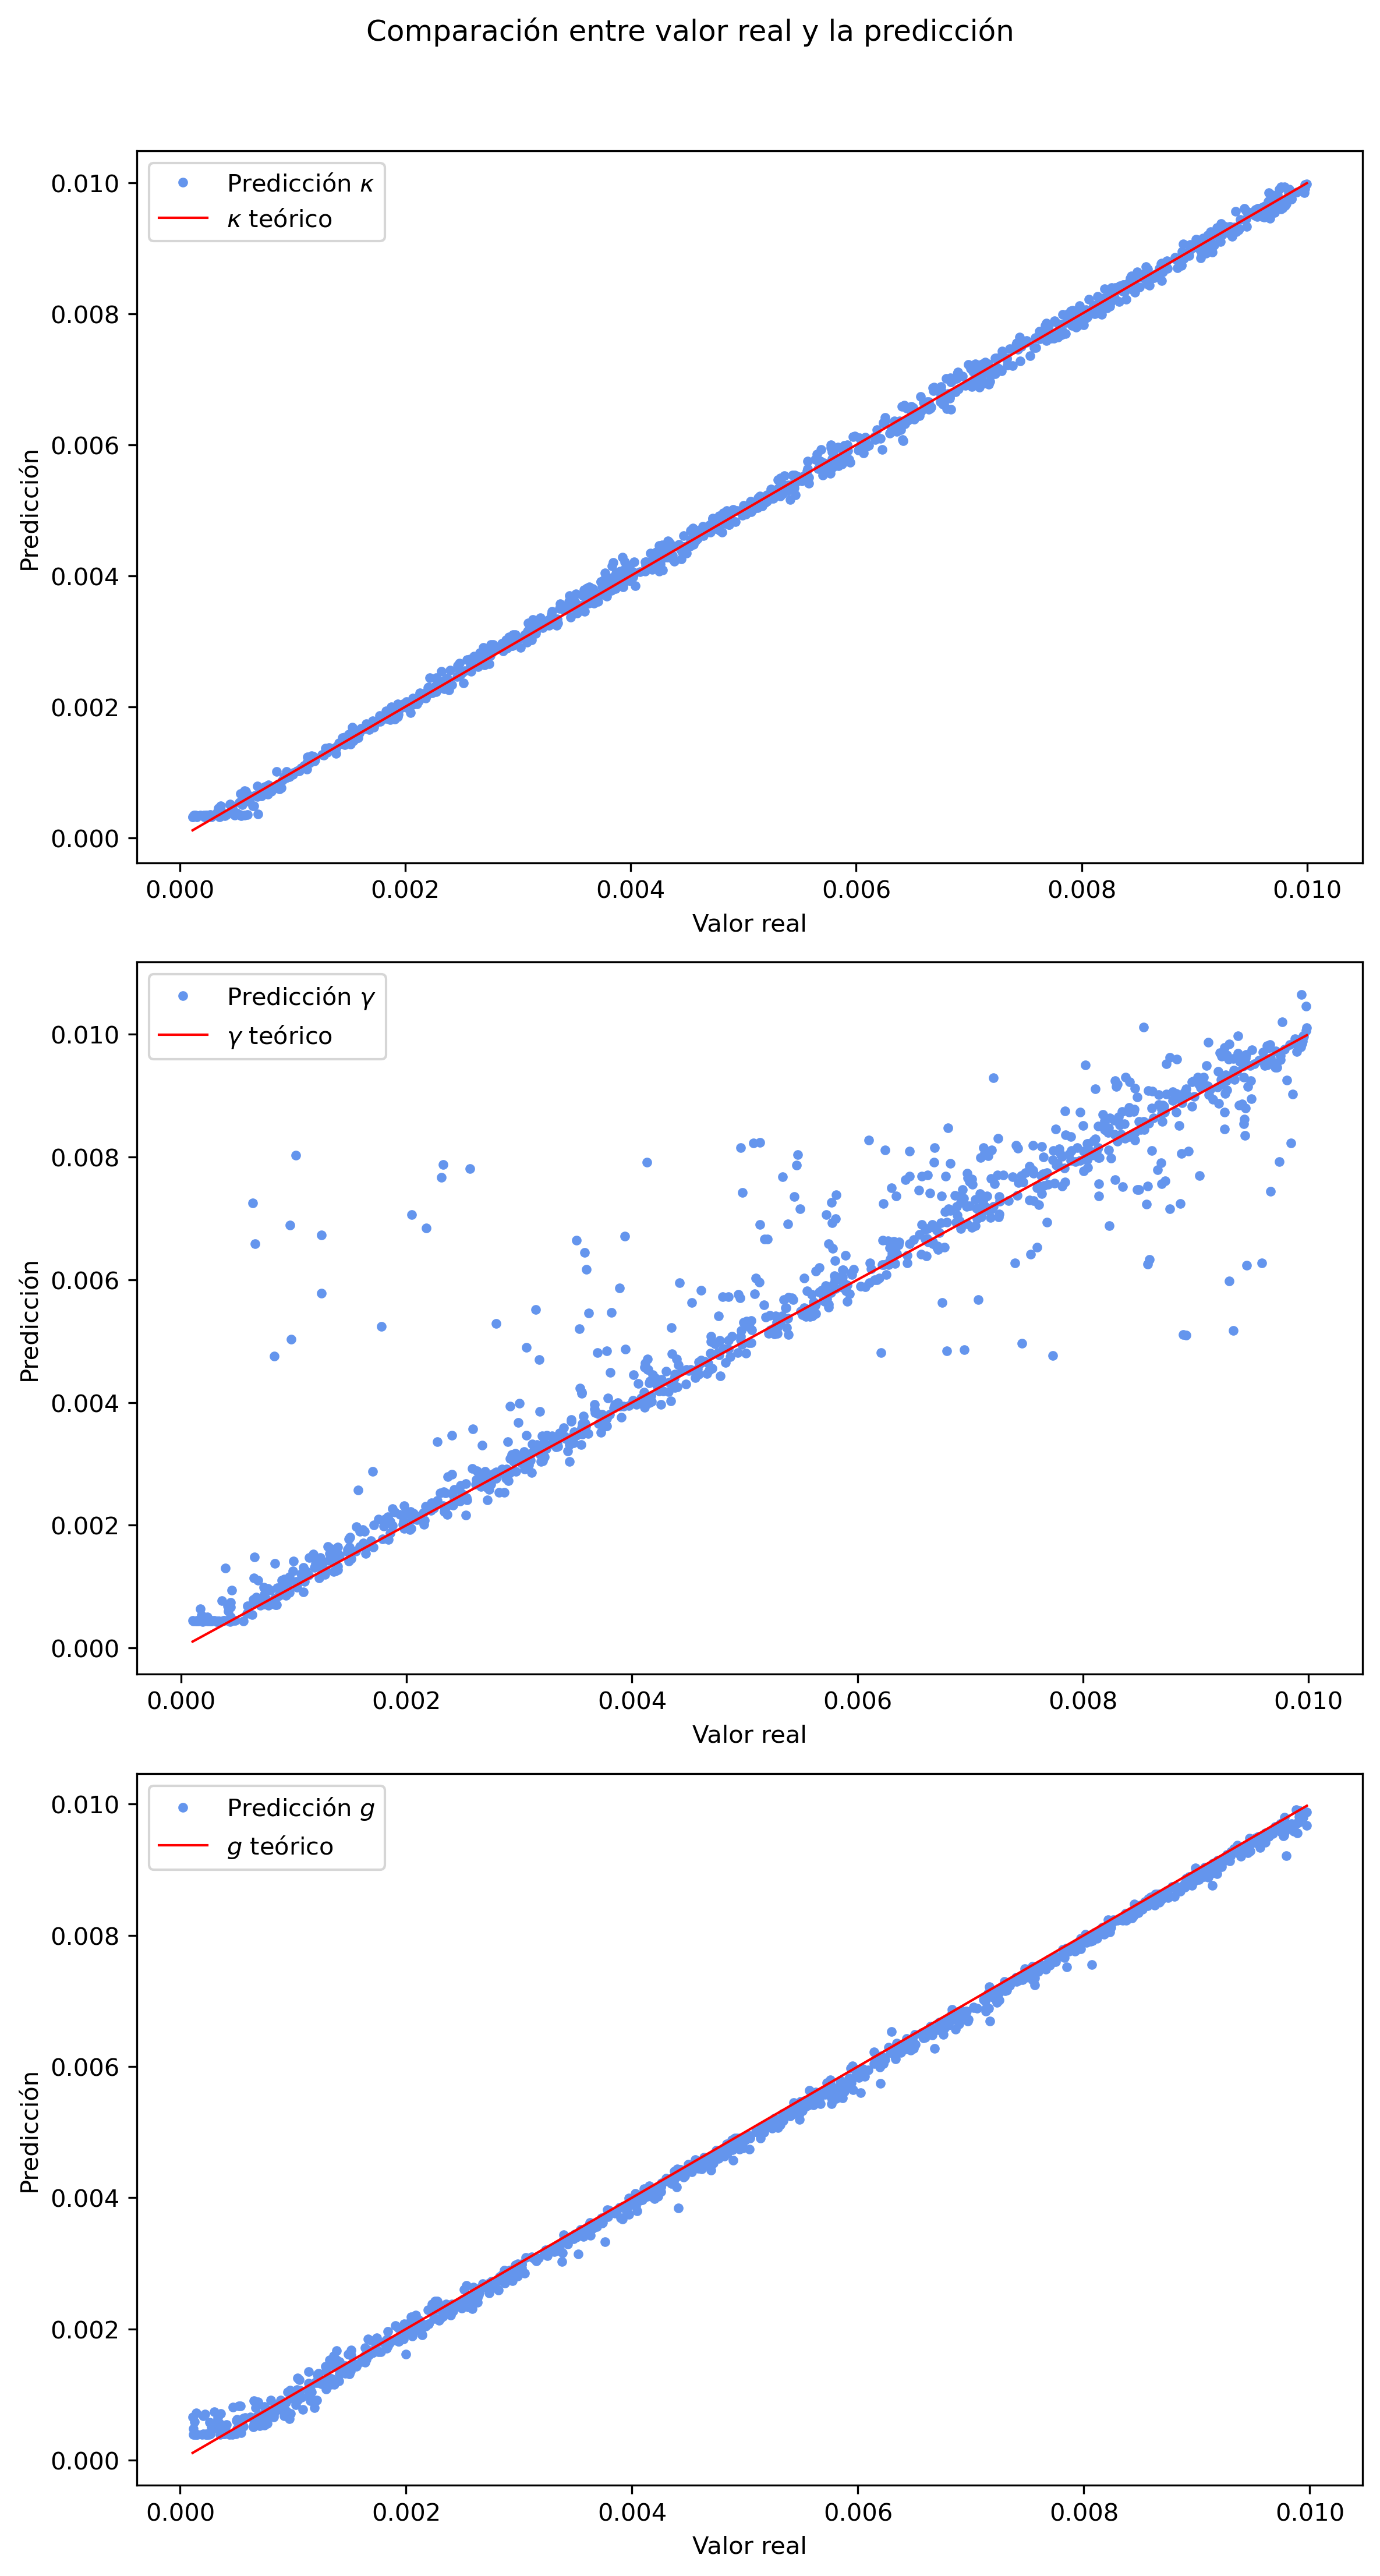

In [13]:
# Desnormalizamos los datos de salida de validación
y_val_denorm = scaler_y.inverse_transform(y_val_norm)
y_pred_denorm = scaler_y.inverse_transform(y_pred_norm)

#Dibujamos los datos
symbols = [r'$\kappa$', r'$\gamma$', r'$g$']

# Crear subgráficos para cada variable
fig, axes = plt.subplots(3,1, figsize=(8,15))

fig.suptitle('Comparación entre valor real y la predicción')

for i, ax in enumerate(axes):
    ax.plot(y_val_denorm[:, i], y_pred_denorm[:, i], label=f'Predicción {symbols[i]}', marker='o', linestyle='',
             markersize=3, color='cornflowerblue')
    ax.plot([y_val_denorm[:, i].min(), y_val_denorm[:, i].max()], [y_val_denorm[:, i].min(), y_val_denorm[:, i].max()],
            linestyle='-', color='red', linewidth=1, label=f'{symbols[i]} teórico')
    ax.set_xlabel('Valor real')
    ax.set_ylabel('Predicción')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



##### ***Contour plot*** predicción vs validación

<Figure size 2700x1500 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

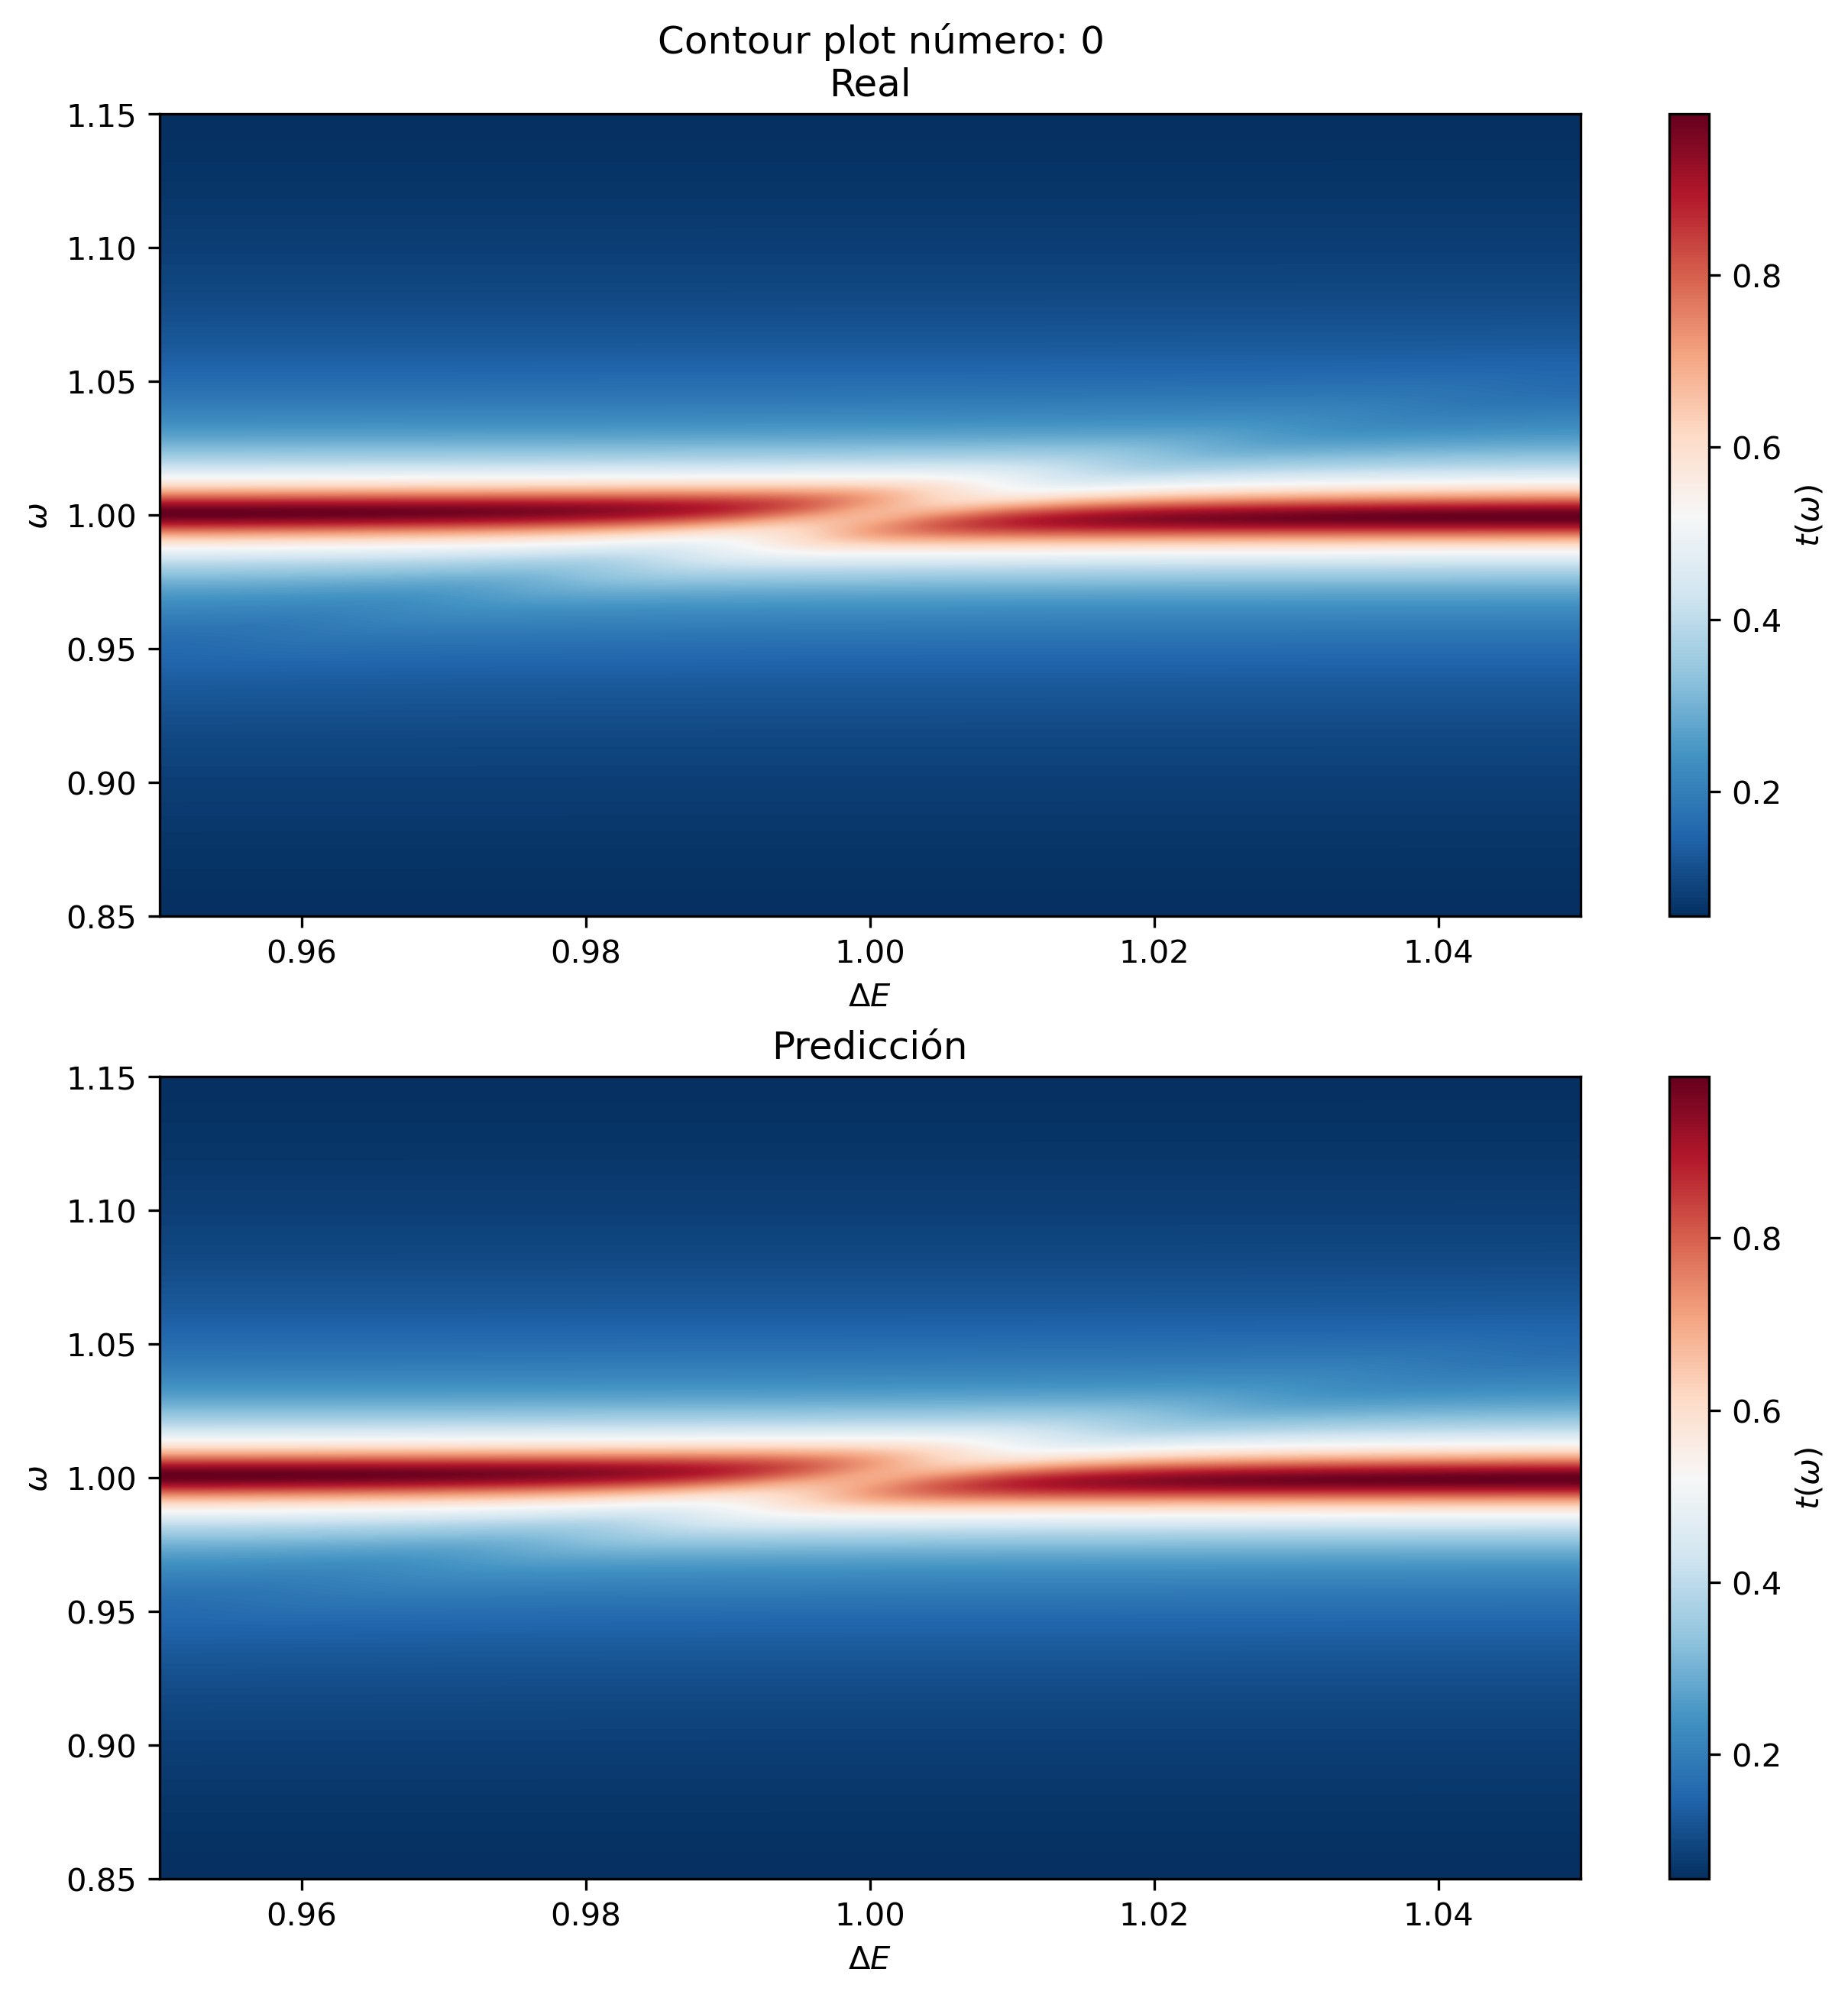

In [14]:
k_pred = y_pred_denorm[:, 0]
k_val = y_val_denorm[:, 0]
gamma_pred = y_pred_denorm[:, 1]
gamma_val = y_val_denorm[:, 1]
g_pred = y_pred_denorm[:, 2]
g_val = y_val_denorm[:, 2]

t_values_pred = np.zeros((x_val.shape[0], len(DeltaE_values), len(w_values)))
t_values_val = np.zeros((x_val.shape[0], len(DeltaE_values), len(w_values)))


for i in range (x_val.shape[0]):
    for j, DeltaE  in enumerate(DeltaE_values):
        t_values_pred[i,j,:] = t_w(w_values, k_pred[i], Omega, DeltaE, gamma_pred[i], g_pred[i])
        t_values_val[i,j,:] = t_w(w_values, k_val[i], Omega, DeltaE, gamma_val[i], g_val[i])


i=0
while i<=1000:
    plt.clf()  # Limpia la figura antes de cada iteración

    plt.figure(figsize=(10,10))
    plt.suptitle(f"Contour plot número: {i}",x=0.44, y=0.92)
    plt.subplot(2, 1, 1)  # Subplot para la imagen t_values_val
    plt.imshow(t_values_val[i,:,:].T, extent=[DeltaE_values.min(), DeltaE_values.max(), w_values.min(), w_values.max()],
                    cmap='RdBu_r', origin='lower',
                      aspect='auto', interpolation='spline16') 
    plt.colorbar(label=r'$t(\omega)$')
    plt.title("Real")
    plt.xlabel(r'$\Delta E$')
    plt.ylabel(r'$\omega$')

    plt.subplot(2, 1, 2)  # Subplot para la imagen t_values_pred
    plt.imshow(t_values_pred[i, :, :].T, extent=[DeltaE_values.min(), DeltaE_values.max(), w_values.min(), w_values.max()],
               cmap='RdBu_r', origin='lower',
               aspect='auto', interpolation='spline16')
    plt.colorbar(label=r'$t(\omega)$')
    plt.xlabel(r'$\Delta E$')
    plt.ylabel(r'$\omega$')
    plt.title("Predicción")

    plt.subplots_adjust(hspace=0.2)

    display(plt.gcf())
    clear_output(wait=True)
    
    if keyboard.is_pressed('esc'): break
    if keyboard.is_pressed('right'): i += 1
    if keyboard.is_pressed('left'): 
        i -= 1       
        if i < 0:
            i += 1